100%|██████████| 2948/2948 [00:06<00:00, 471.29it/s]


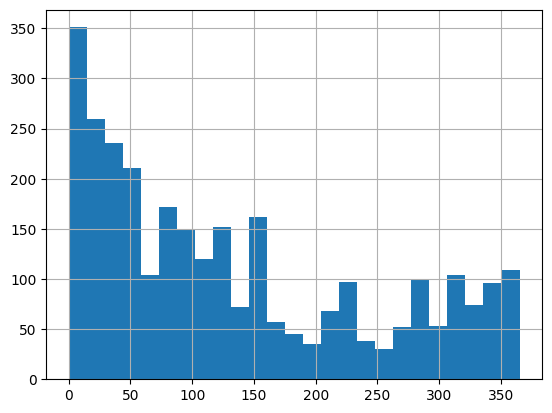

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, MandrillTripleImageDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
# data = filter_by_qty(data, bins=50, qty_per_bin=5)

hist = data["age"].hist(bins=25)

single_dataset = MandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, max_days=max_days)
dataset = MandrillTripleImageDataset(root_dir='Images', dataframe=data, in_mem=False, max_days=max_days)
dataset.set_images(single_dataset.images)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

from mandrill.utils import split_dataset, load, save
from mandrill.models import VGGFace, RegressionModel
from mandrill.losses import TripletLossAdaptiveMargin
from mandrill.display import plot_latent_space
    
def train_step(loader, index, optimizer, model, criterion):
    (i1, i2, i3), margin = next(iter(loader))
    optimizer.zero_grad()

    # Forward pass
    i1, i2, i3, margin = i1.to(device), i2.to(device), i3.to(device), margin.to(device)
    o1, o2, o3 = model(i1), model(i2), model(i3)
    loss = criterion(o1, o2, o3, margin)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    size = i1.size(0)

    return loss.item() * size
    
def train_regressor_step(train_single_loader, index, regressor_optimizer, backbone, regressor_model, regressor_criterion):
    x, y = next(iter(train_single_loader))
    regressor_optimizer.zero_grad()

    # Forward pass
    x, y = x.to(device), y.to(device)
    if backbone:
        x = backbone(x)
    y_hat = regressor_model(x)
    loss = regressor_criterion(y_hat, y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    return loss.item() * x.size(0)
    
learning_rate = 1e-4
regressor_learning_rate = 1e-4

batch_size = 32
num_epochs = 100
train_ratio = 0.8
num_workers = 0
prefetch_factor = None

# Dataset and DataLoader
torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)
train_single_loader, val_single_loader, _, val_single_dataset = split_dataset(single_dataset, train_ratio, batch_size, augment=False)
dataloader = val_single_loader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Model
model = VGGFace()
model = model.to(device)
regressor_model = RegressionModel(cnn_backbone=model, input_dim=model.output_dim, n_lin=6, lin_start=2048, sigmoid=True)
regressor_model = regressor_model.to(device)

# Loss function
criterion = TripletLossAdaptiveMargin()
val_criterion = TripletLossAdaptiveMargin()
regressor_criterion = nn.MSELoss()
regressor_val_criterion = nn.L1Loss()

start_triplet_epoch = 0

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
regressor_optimizer = optim.Adam(regressor_model.parameters(), lr=regressor_learning_rate)

#######
train = False
#######

name = "exp_triplet_reg"

# model = load(model, "backbone", exp_name=name)
regressor_model = load(regressor_model, "best_reg", exp_name="exp_rank_classif_reg")
if train:
    # Training loop
    best_val = np.inf
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        regressor_model.train()  # Set the model to train mode

        train_loss = 0.0
        regressor_train_loss = 0.0
        steps = len(train_loader)

        pbar = tqdm(range(steps))
        for i in pbar:
            if epoch >= start_triplet_epoch:
                train_loss += train_step(train_loader, i, optimizer, model, criterion)
            regressor_train_loss += train_regressor_step(train_single_loader, i, regressor_optimizer, None, regressor_model, regressor_criterion)
            
            n_samples = batch_size * (i+1)
            pbar.set_description(f"Train Loss: {(train_loss/n_samples):.5f} - Regression train loss: {(regressor_train_loss/n_samples):.5f} - ")
            
        train_loss /= len(train_dataset)
        regressor_train_loss /= len(train_dataset)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        regressor_model.eval()
        val_loss = 0.0
        val_loss_regressor = 0.0

        with torch.no_grad():
            for (i1, i2, i3), margin in tqdm(val_loader):
                i1, i2, i3, margin = i1.to(device), i2.to(device), i3.to(device), margin.to(device)
                o1, o2, o3 = model(i1), model(i2), model(i3)
                loss = val_criterion(o1, o2, o3, margin)
                val_loss += loss.item() * i1.size(0)
                
            for x, y in tqdm(val_single_loader):
                x, y = x.to(device), y.to(device)
                y_hat = regressor_model(x)
                loss = regressor_val_criterion(y_hat, y)
                val_loss_regressor += loss.item() * x.size(0)
                
        val_loss /= len(val_dataset)
        val_loss_regressor /= len(val_dataset)

        if val_loss < best_val:
            print(f"Val loss improved from {best_val:.4f} to {val_loss:.4f}")
            best_val = val_loss
            save(model, "backbone", exp_name=name)
            save(regressor_model, "regressor", exp_name=name)
        else:
            print(f"Val loss did not improved from {best_val:.4f}")

        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.5f} - "
              f"Regression train loss: {regressor_train_loss:.5f} - "
              f"Val Loss: {val_loss:.5f}"
              f"Regression val loss: {val_loss_regressor:.5f}"
        )
        plot_latent_space(model, dataloader, device)

Using device: cuda


In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
torch.manual_seed(0)

regressor_model = load(regressor_model, "regressor", exp_name=name)
regressor_model.eval()

val_loader = DataLoader(val_single_dataset, batch_size=1, shuffle=False)

max_display = 0

y_true = []
y_pred = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = regressor_model(images)
    
    # Convert the outputs to numpy arrays
    pred = outputs.squeeze().detach().cpu().numpy() * 365
    target = targets.squeeze().cpu().numpy() * 365
    
    y_true.append(target)
    y_pred.append(pred)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", pred)
    print("Actual Values:", target)
    print("Prediction Error: ", pred - target)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {pred}, Actual: {target}")
    plt.show()

    val_loader = DataLoader(val_single_dataset, batch_size=1, shuffle=False)

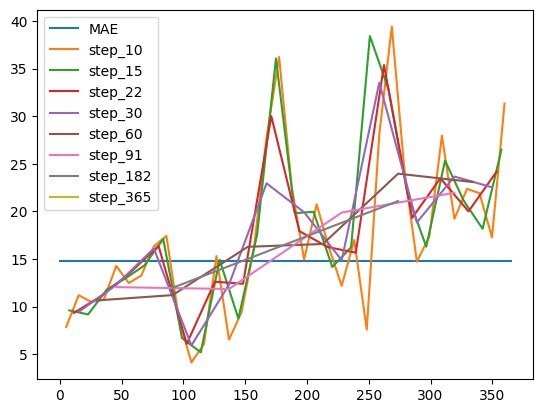

Accuracy: 0.2949
Precision: 0.2309
Recall: 0.2451
F1-score: 0.2235


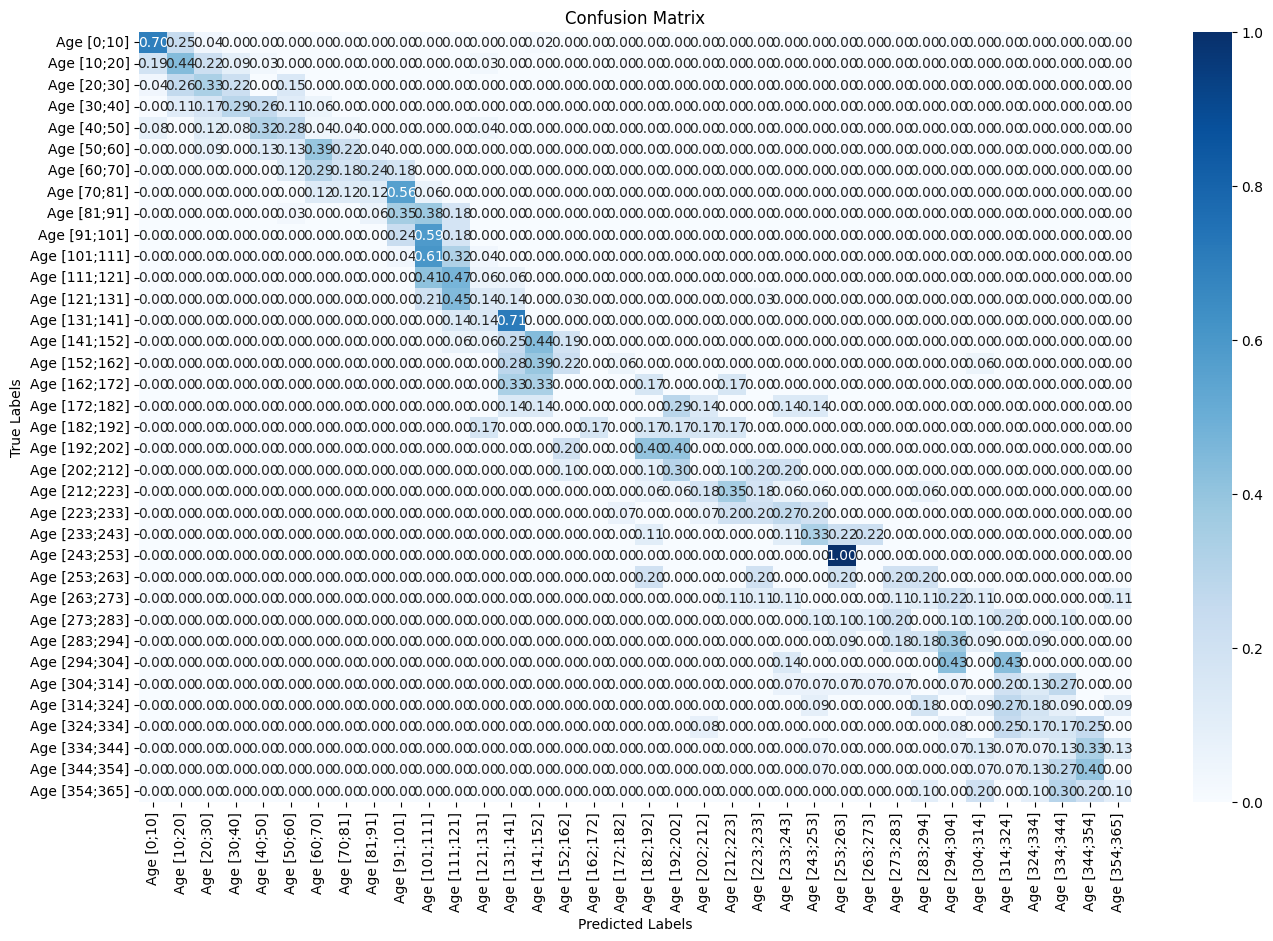

Accuracy: 0.3797
Precision: 0.3083
Recall: 0.3253
F1-score: 0.2968


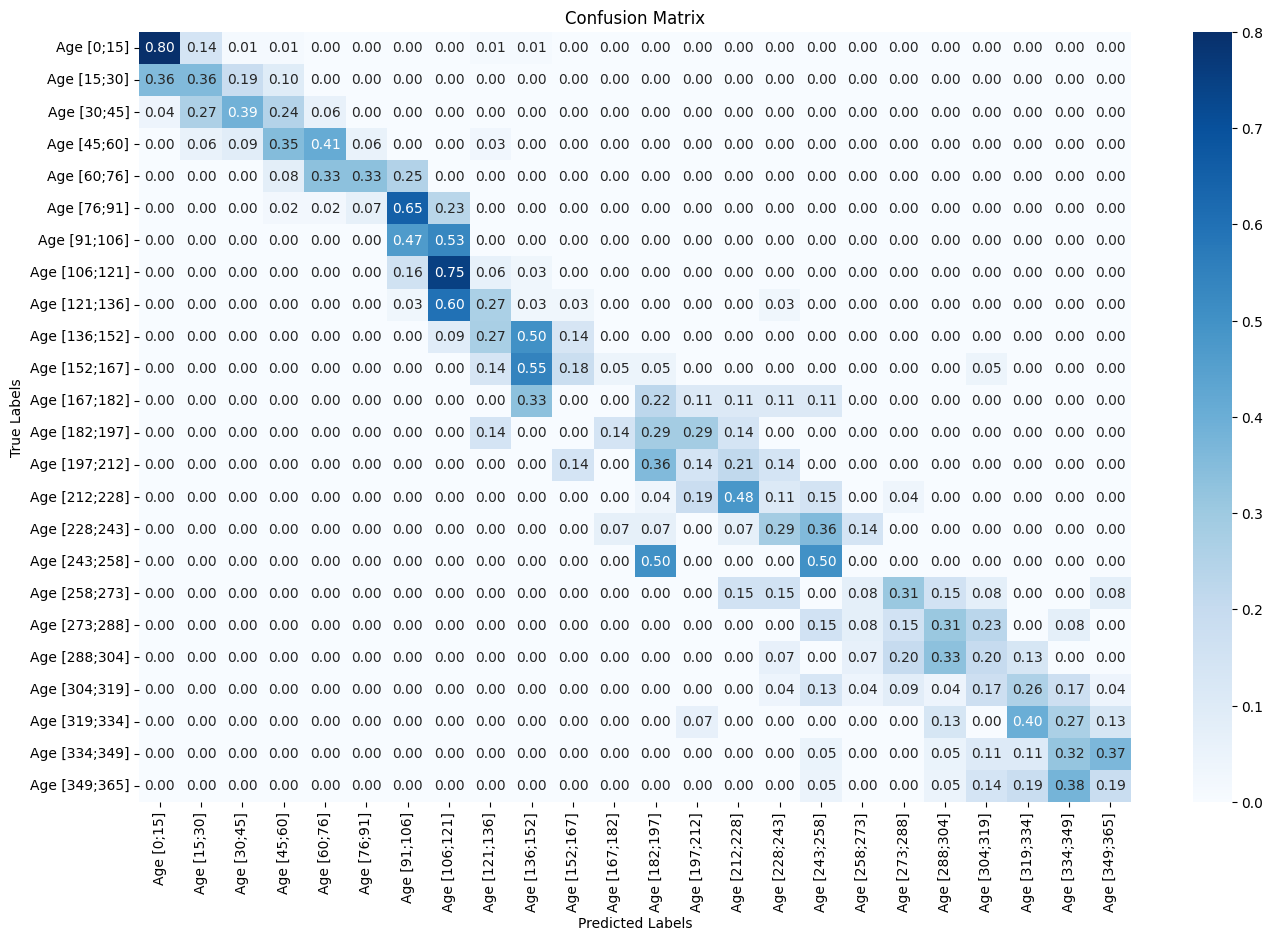

Accuracy: 0.5305
Precision: 0.4568
Recall: 0.4588
F1-score: 0.4416


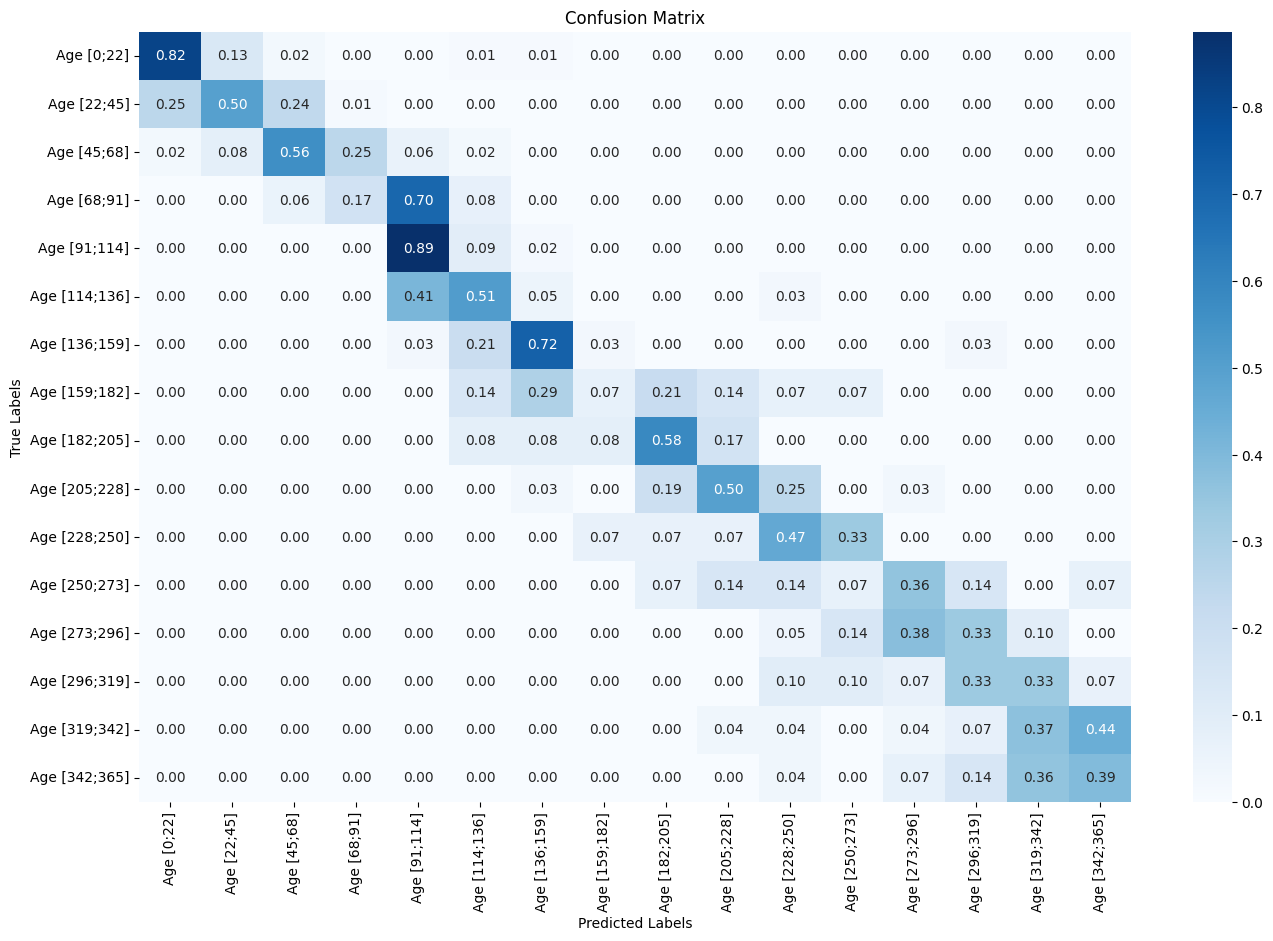

Accuracy: 0.5780
Precision: 0.5148
Recall: 0.5032
F1-score: 0.4943


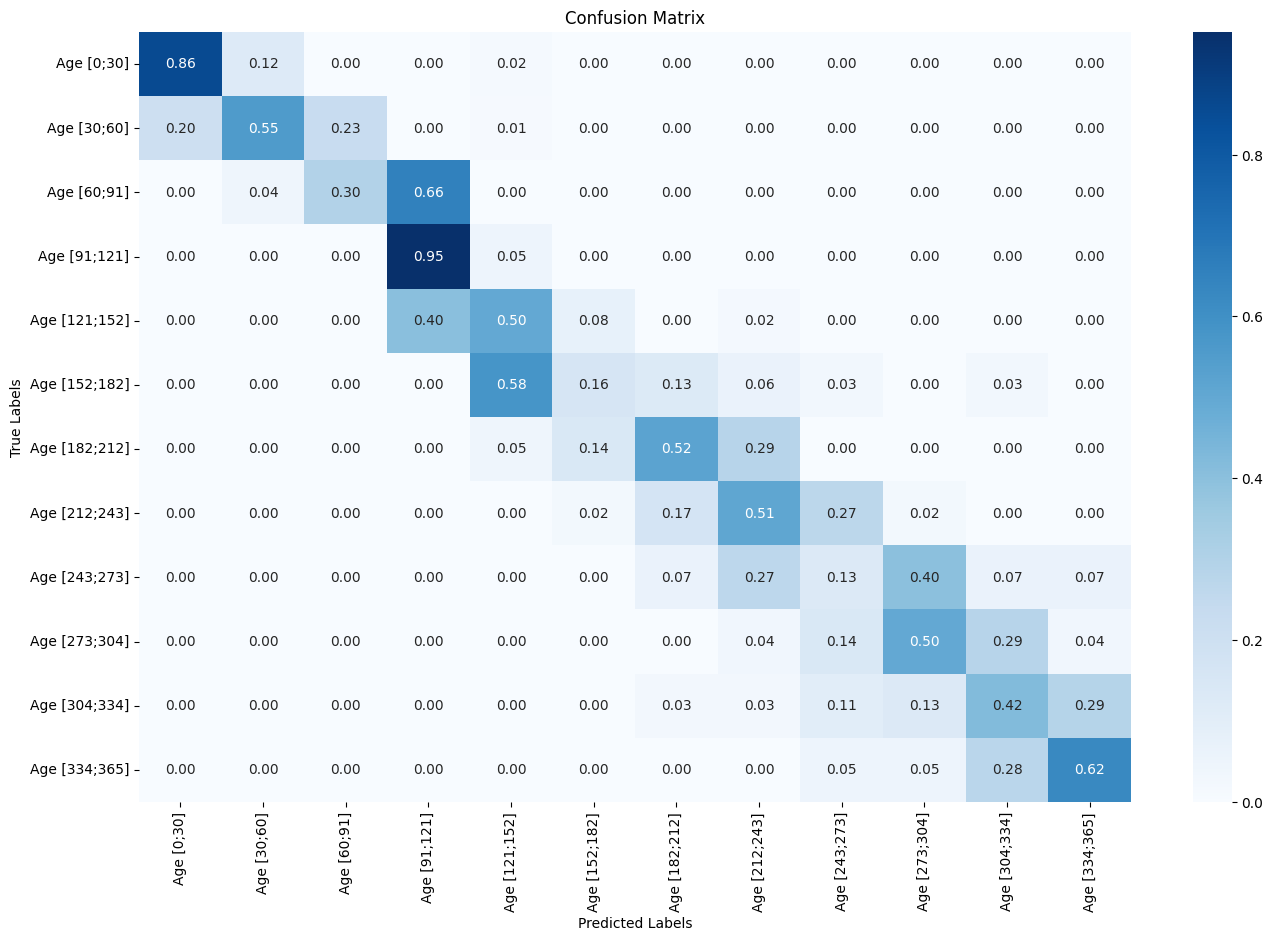

Accuracy: 0.8186
Precision: 0.7759
Recall: 0.7696
F1-score: 0.7675


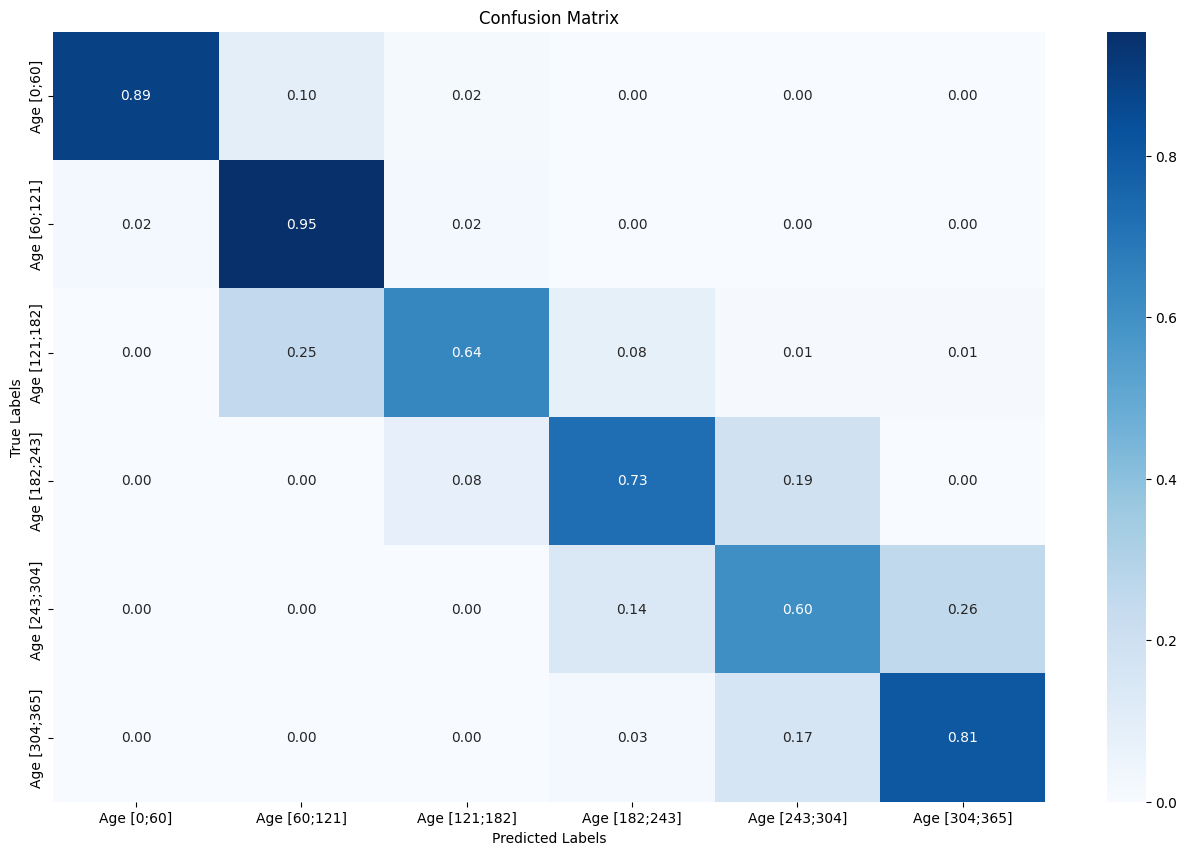

Accuracy: 0.8593
Precision: 0.8441
Recall: 0.8635
F1-score: 0.8477


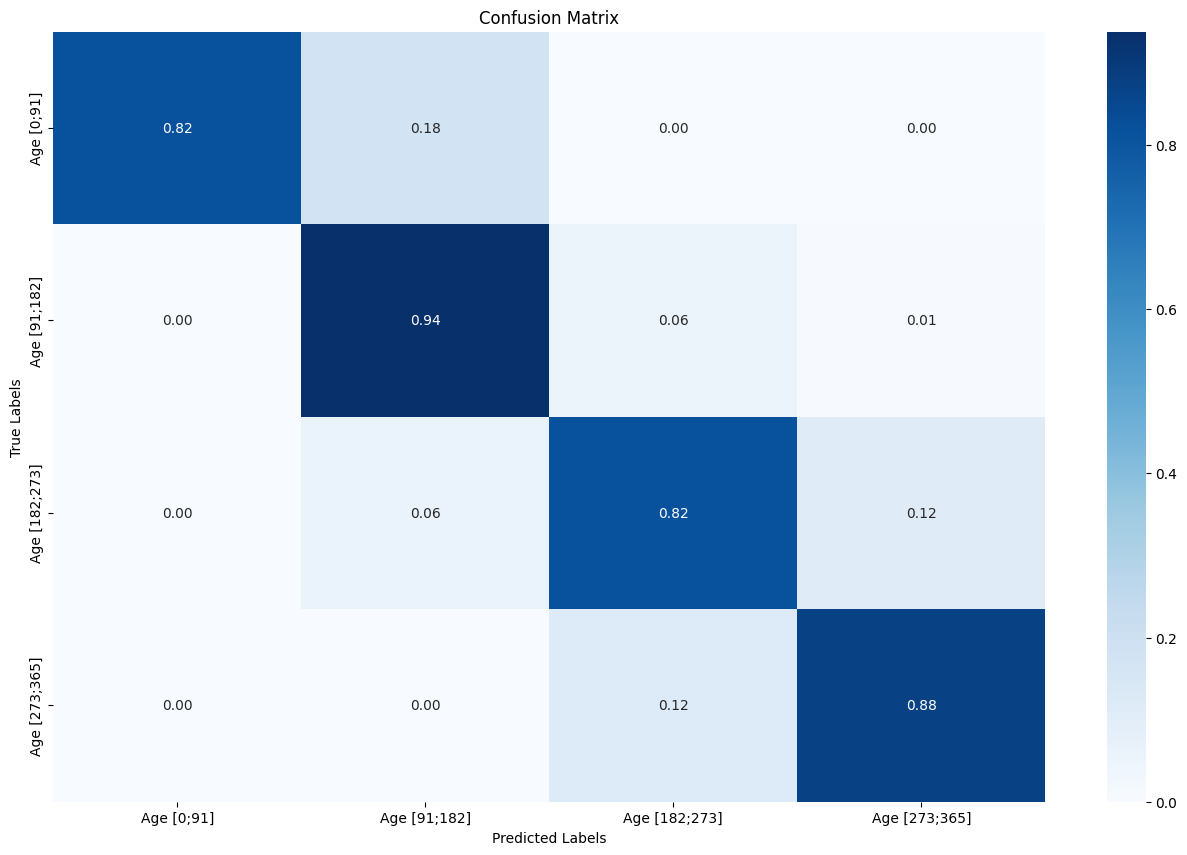

Accuracy: 0.9763
Precision: 0.9697
Recall: 0.9753
F1-score: 0.9724


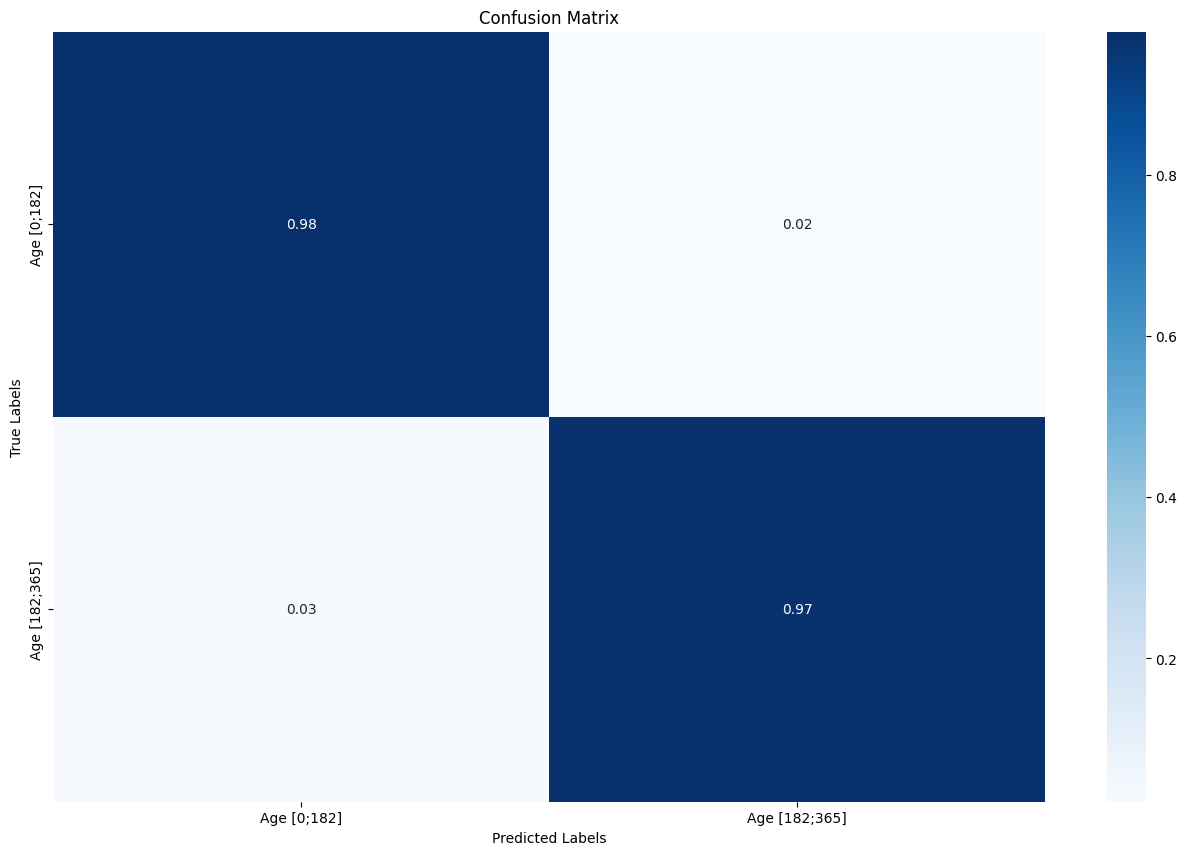

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


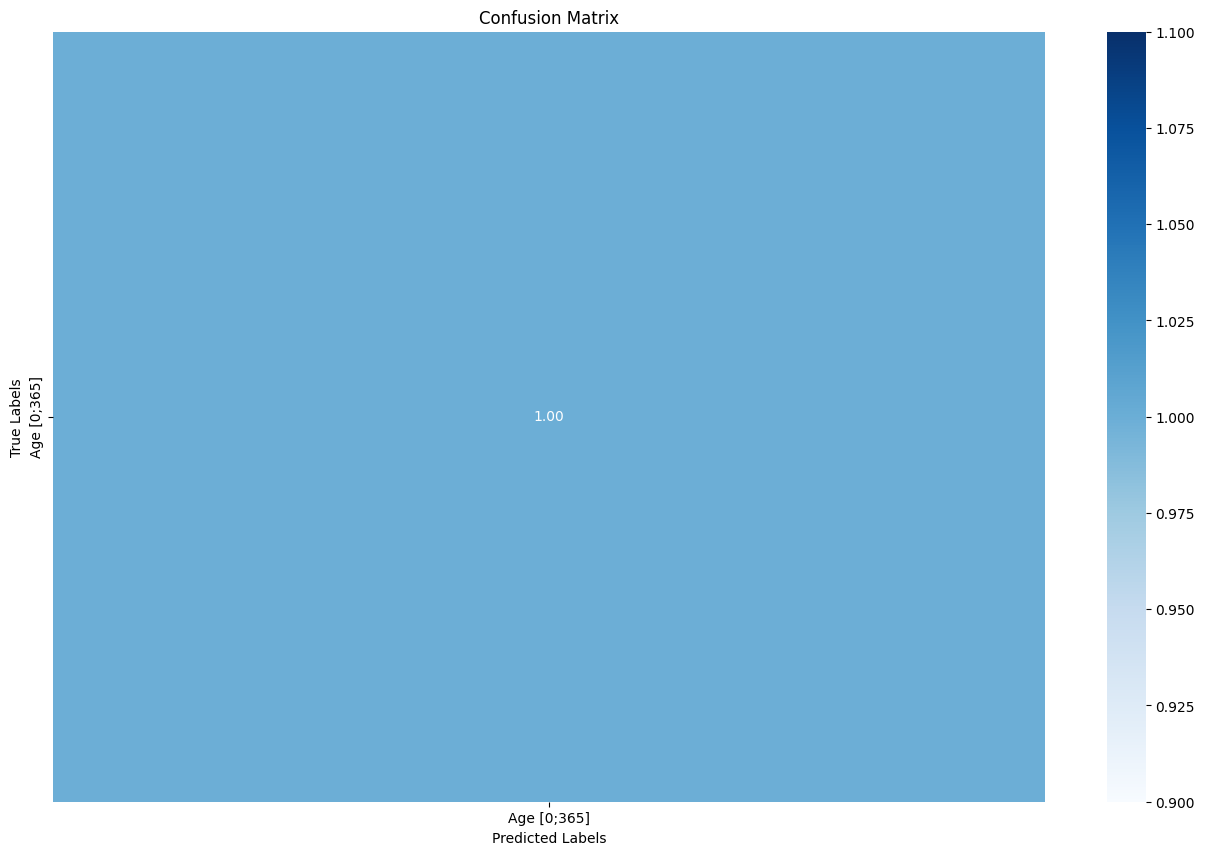

{'vgg_face_rank_regression': {'vgg_face_rank_regression_regression': {'vgg_face_rank_regression_regression_mae': 14.794635606766969,
   'vgg_face_rank_regression_regression_mae_steps': {10.13888888888889: [(5.069444444444445,
      7.841260574080153),
     (15.208333333333334, 11.19480482477229),
     (25.34722222222222, 10.486956672329041),
     (35.486111111111114, 10.719345504151923),
     (45.625, 14.266449085232306),
     (55.763888888888886, 12.470851827250874),
     (65.90277777777779, 13.249435380977744),
     (76.04166666666667, 16.32234742399305),
     (86.18055555555556, 17.419557466226465),
     (96.31944444444444, 8.711665079874152),
     (106.45833333333334, 4.122675518904414),
     (116.59722222222223, 6.046012035187553),
     (126.73611111111111, 15.302540870576069),
     (136.875, 6.523454572473254),
     (147.0138888888889, 9.37985043041408),
     (157.15277777777777, 16.183078529106247),
     (167.29166666666669, 27.733513191342354),
     (177.43055555555554, 36.2108

In [4]:
from mandrill.evaluations import standard_regression_evaluation

standard_regression_evaluation(np.array(y_true), np.array(y_pred), "vgg_face_rank_regression", 0, max_days)